# Oxford-IIIT Pets + Caltech 256: Multi-Task & Triplet Learning

## 📄 Project Overview

This repository presents an extensive study of multi-task learning (image classification + semantic segmentation) and metric learning using triplet loss applied on two renowned datasets:

Oxford-IIIT Pet Dataset: used for simultaneous classification and segmentation

Caltech-256 Object Categories: used for image retrieval and identity verification with triplet networks

Deep learning techniques (CNNs and transfer learning with MobileNet and InceptionV3) and classic machine learning (PCA, LDA, logistic regression) are combined to evaluate and benchmark multiple models.

In [1]:
import os
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-06-02 10:41:51.167071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 10:41:51.319403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 10:41:51.319431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 10:41:51.345158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 10:41:51.409154: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Load dataset
def load_dataset(base_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_path))

    for category in class_names:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            image_files = [img_file for img_file in os.listdir(category_path) if img_file.endswith('.jpg')]
            if not image_files:
                print(f"Skipping empty folder: {category_path}")
                continue
            for img_file in image_files:
                image_path = os.path.join(category_path, img_file)
                images.append(image_path)
                labels.append(category)
    return images, labels, class_names

# Define paths
base_path = '/home/imhaom/CAB420_Machine_Learning/Assignment_2/256_ObjectCategories'
images, labels, class_names = load_dataset(base_path)

# Split data into train+val and test
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Split train+val into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.25, random_state=42, stratify=train_val_labels)

# Ensure correct matching of images and labels before feature extraction
assert len(train_images) == len(train_labels), "Mismatch in train images and labels"
assert len(val_images) == len(val_labels), "Mismatch in val images and labels"
assert len(test_images) == len(test_labels), "Mismatch in test images and labels"

print (f"Number of training images: {len(train_images)}")
print (f"Number of validation images: {len(val_images)}")
print (f"Number of testing images: {len(test_images)}")
print (train_val_images[0], train_val_labels[0])
print (train_images[0], train_labels[0])
print (test_images[0], test_labels[0])
print (val_images[0], val_labels[0])

Number of training images: 18363
Number of validation images: 6122
Number of testing images: 6122
/home/imhaom/CAB420_Machine_Learning/Assignment_2/256_ObjectCategories/034.centipede/034_0072.jpg 034.centipede
/home/imhaom/CAB420_Machine_Learning/Assignment_2/256_ObjectCategories/017.bowling-ball/017_0074.jpg 017.bowling-ball
/home/imhaom/CAB420_Machine_Learning/Assignment_2/256_ObjectCategories/209.sword/209_0063.jpg 209.sword
/home/imhaom/CAB420_Machine_Learning/Assignment_2/256_ObjectCategories/251.airplanes-101/251_0255.jpg 251.airplanes-101


In [3]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Batch feature extraction function
def extract_features(image_paths, model, datagen=None, batch_size=32):
    features = []
    num_batches = len(image_paths) // batch_size + (1 if len(image_paths) % batch_size != 0 else 0)
    for i in range(num_batches):
        batch_paths = image_paths[i * batch_size: (i + 1) * batch_size]
        batch_images = np.array([load_image(path) for path in batch_paths])
        if datagen:
            batch_images = next(datagen.flow(batch_images, batch_size=batch_size, shuffle=False))
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        gc.collect()
    return np.concatenate(features, axis=0)

# Check if the features are already saved
if os.path.exists('train_features_v2.npy') and os.path.exists('val_features_v2.npy') and os.path.exists('test_features_v2.npy'):
    # Load the extracted features from disk
    train_features = np.load('train_features_v2.npy')
    val_features = np.load('val_features_v2.npy')
    test_features = np.load('test_features_v2.npy')
else:
    # Extract features and save them
    train_features = extract_features(train_images, model, datagen=datagen)
    val_features = extract_features(val_images, model)
    
    test_features = extract_features(test_images, model)

    # Save the extracted features to disk
    np.save('train_features_v2.npy', train_features)
    np.save('val_features_v2.npy', val_features)
    np.save('test_features_v2.npy', test_features)
    
print (f"Train features shape: {train_features.shape}")
print (f"Validation features shape: {val_features.shape}")
print (f"Test features shape: {test_features.shape}")

2024-06-02 10:41:53.942846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 10:41:54.029317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 10:41:54.029363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 10:41:54.032568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-02 10:41:54.032617: I external/local_xla/xla/stream_executor

Train features shape: (18363, 8, 8, 2048)
Validation features shape: (6122, 8, 8, 2048)
Test features shape: (6122, 8, 8, 2048)


In [5]:
def create_triplets(image_paths, labels, num_triplets):
    triplets = []
    label_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    for _ in range(num_triplets):
        anchor_label = np.random.choice(labels)
        anchor_idx = np.random.choice(label_indices[anchor_label])
        positive_idx = np.random.choice(label_indices[anchor_label])

        negative_label = np.random.choice(labels[labels != anchor_label])
        negative_idx = np.random.choice(label_indices[negative_label])

        triplet = (image_paths[anchor_idx], image_paths[positive_idx], image_paths[negative_idx])
        triplets.append(triplet)

    return triplets

train_triplet_paths = create_triplets(train_images, np.array(train_labels), num_triplets=50000)
val_triplet_paths = create_triplets(val_images, np.array(val_labels), num_triplets=5000)

def triplet_generator(triplet_paths, batch_size, input_shape):
    def gen():
        num_triplets = len(triplet_paths)
        while True:
            for i in range(0, num_triplets, batch_size):
                batch_triplets = triplet_paths[i:i + batch_size]
                anchor_images = np.zeros((batch_size, *input_shape))
                positive_images = np.zeros((batch_size, *input_shape))
                negative_images = np.zeros((batch_size, *input_shape))

                for j in range(len(batch_triplets)):
                    anchor_path, positive_path, negative_path = batch_triplets[j]
                    anchor_images[j] = load_image(anchor_path).numpy()
                    positive_images[j] = load_image(positive_path).numpy()
                    negative_images[j] = load_image(negative_path).numpy()

                yield (tf.convert_to_tensor(anchor_images, dtype=tf.float32),
                       tf.convert_to_tensor(positive_images, dtype=tf.float32),
                       tf.convert_to_tensor(negative_images, dtype=tf.float32)), \
                      tf.convert_to_tensor(np.zeros((batch_size, 3, 128)), dtype=tf.float32)

    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, 299, 299, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, 299, 299, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, 299, 299, 3), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(batch_size, 3, 128), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

# Create the generators
train_gen = triplet_generator(train_triplet_paths, batch_size=32, input_shape=(299, 299, 3))
val_gen = triplet_generator(val_triplet_paths, batch_size=32, input_shape=(299, 299, 3))

def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(pos_dist - neg_dist + alpha, 0.0)
    return tf.reduce_mean(loss)

print (train_gen)
print (val_gen)

<_FlatMapDataset element_spec=((TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 3, 128), dtype=tf.float32, name=None))>
<_FlatMapDataset element_spec=((TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 3, 128), dtype=tf.float32, name=None))>


In [6]:
def identity_block(x, filters, kernel_size):
    x_skip = x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

def simple_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    for _ in range(3):
        x = identity_block(x, 64, (3, 3))
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='relu')(x)
    model = Model(inputs, x)
    return model

In [7]:
def stack_vectors(x):
    return tf.stack(x, axis=1)

# Define the triplet model using the custom ResNet
def create_triplet_model(input_shape):
    base_model = simple_resnet(input_shape, num_classes=128)
    base_model_output = base_model.output

    embedding_model = Model(inputs=base_model.input, outputs=base_model_output)

    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")

    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)

    merged_vector = Lambda(stack_vectors)([encoded_anchor, encoded_positive, encoded_negative])

    triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
    return triplet_model

model_load_path = '/home/imhaom/CAB420_Machine_Learning/Assignment_2/triplet_model_V2.keras'
input_shape = (299, 299, 3)
triplet_model = create_triplet_model(input_shape)
triplet_model.compile(optimizer='adam', loss=triplet_loss)

checkpoint_callback = ModelCheckpoint(
    filepath=model_load_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define early stopping callback to stop training when the model stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [8]:
if os.path.exists(model_load_path):
    custom_objects = {'triplet_loss': triplet_loss, 'stack_vectors': stack_vectors}
    triplet_model = load_model(model_load_path, custom_objects=custom_objects, compile=False)
    print("Model loaded successfully.")
else:
    # Define the model if it doesn't exist
    triplet_model.compile(optimizer='adam', loss=triplet_loss)

    # Freeze all layers initially
    for layer in triplet_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning
    for layer in triplet_model.layers[-20:]:
        layer.trainable = True

    # Fine-tune the model with callbacks
    history = triplet_model.fit(
        train_gen,
        steps_per_epoch=len(train_triplet_paths) // 32,
        epochs=20,
        validation_data=val_gen,
        validation_steps=len(val_triplet_paths) // 32,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Gradually unfreeze more layers and continue fine-tuning
    for layer in triplet_model.layers[-50:]:
        layer.trainable = True

    history = triplet_model.fit(
        train_gen,
        steps_per_epoch=len(train_triplet_paths) // 32,
        epochs=20,
        validation_data=val_gen,
        validation_steps=len(val_triplet_paths) // 32,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    triplet_model.save(model_load_path)

Model loaded successfully.


In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


train_features_flat = train_features.reshape((train_features.shape[0], -1))
val_features_flat = val_features.reshape((val_features.shape[0], -1))
test_features_flat = test_features.reshape((test_features.shape[0], -1))

print (train_features_flat.shape)
print (val_features_flat.shape)
print (test_features_flat.shape)

# Apply Truncated SVD
svd = TruncatedSVD(n_components=500)  # Adjust the number of components as needed
train_features_svd = svd.fit_transform(train_features_flat)
val_features_svd = svd.transform(val_features_flat)
test_features_svd = svd.transform(test_features_flat)

# Apply PCA on the reduced data
pca = PCA(n_components=0.95)  # Retain 95% of variance
train_features_pca = pca.fit_transform(train_features_svd)
val_features_pca = pca.transform(val_features_svd)
test_features_pca = pca.transform(test_features_svd)

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Apply LDA
lda = LinearDiscriminantAnalysis()
train_features_lda = lda.fit_transform(train_features_pca, train_labels_encoded)
val_features_lda = lda.transform(val_features_pca)
test_features_lda = lda.transform(test_features_pca)

print (train_features_lda.shape)
print (val_features_lda.shape)
print (test_features_lda.shape)

(18363, 256)
(6122, 256)
(6122, 256)


In [ ]:
# def plot_loss(history):
#     plt.figure(figsize=(10, 5))
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

# plot_loss(history)

Cross-Validation Scores: [0.82820583 0.8309284  0.83147291 0.83088235 0.82107843]
Mean CV Score: 0.8285135834894808
Training Accuracy: 1.00
Training F1 Score: 1.00
Testing Accuracy: 0.83
Testing F1 Score: 0.83


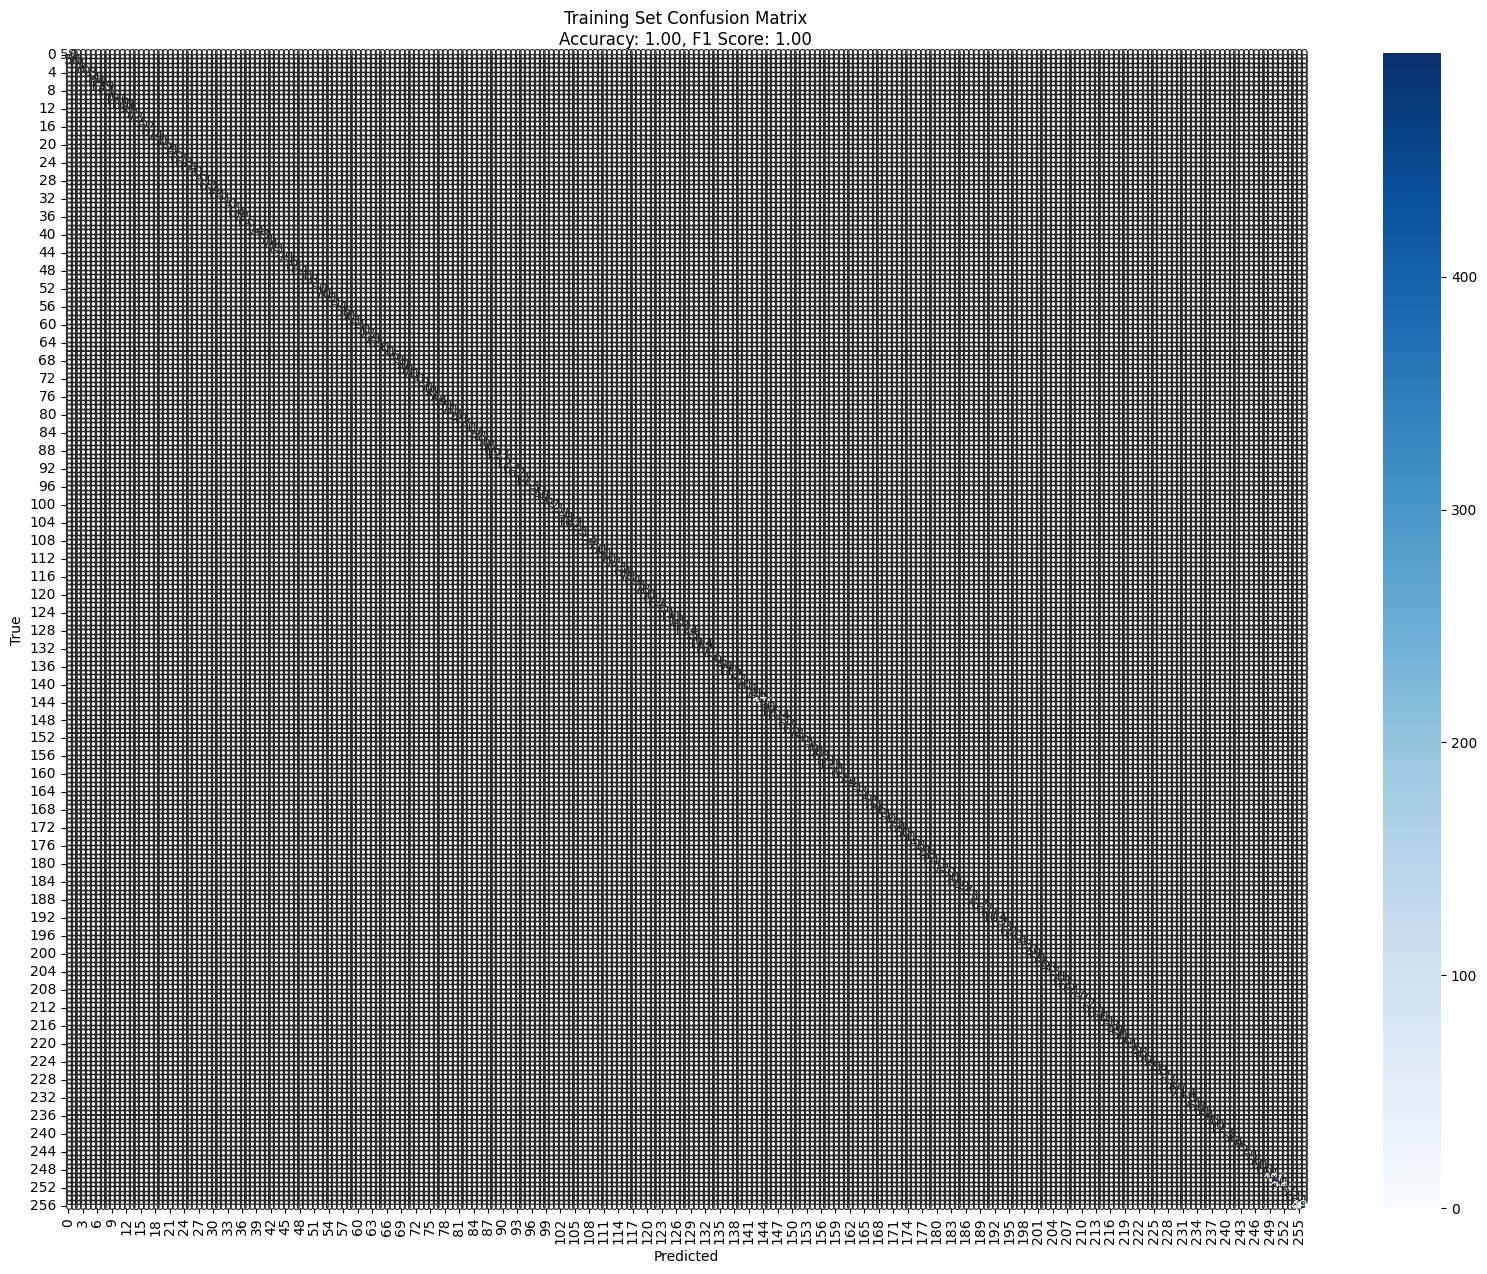

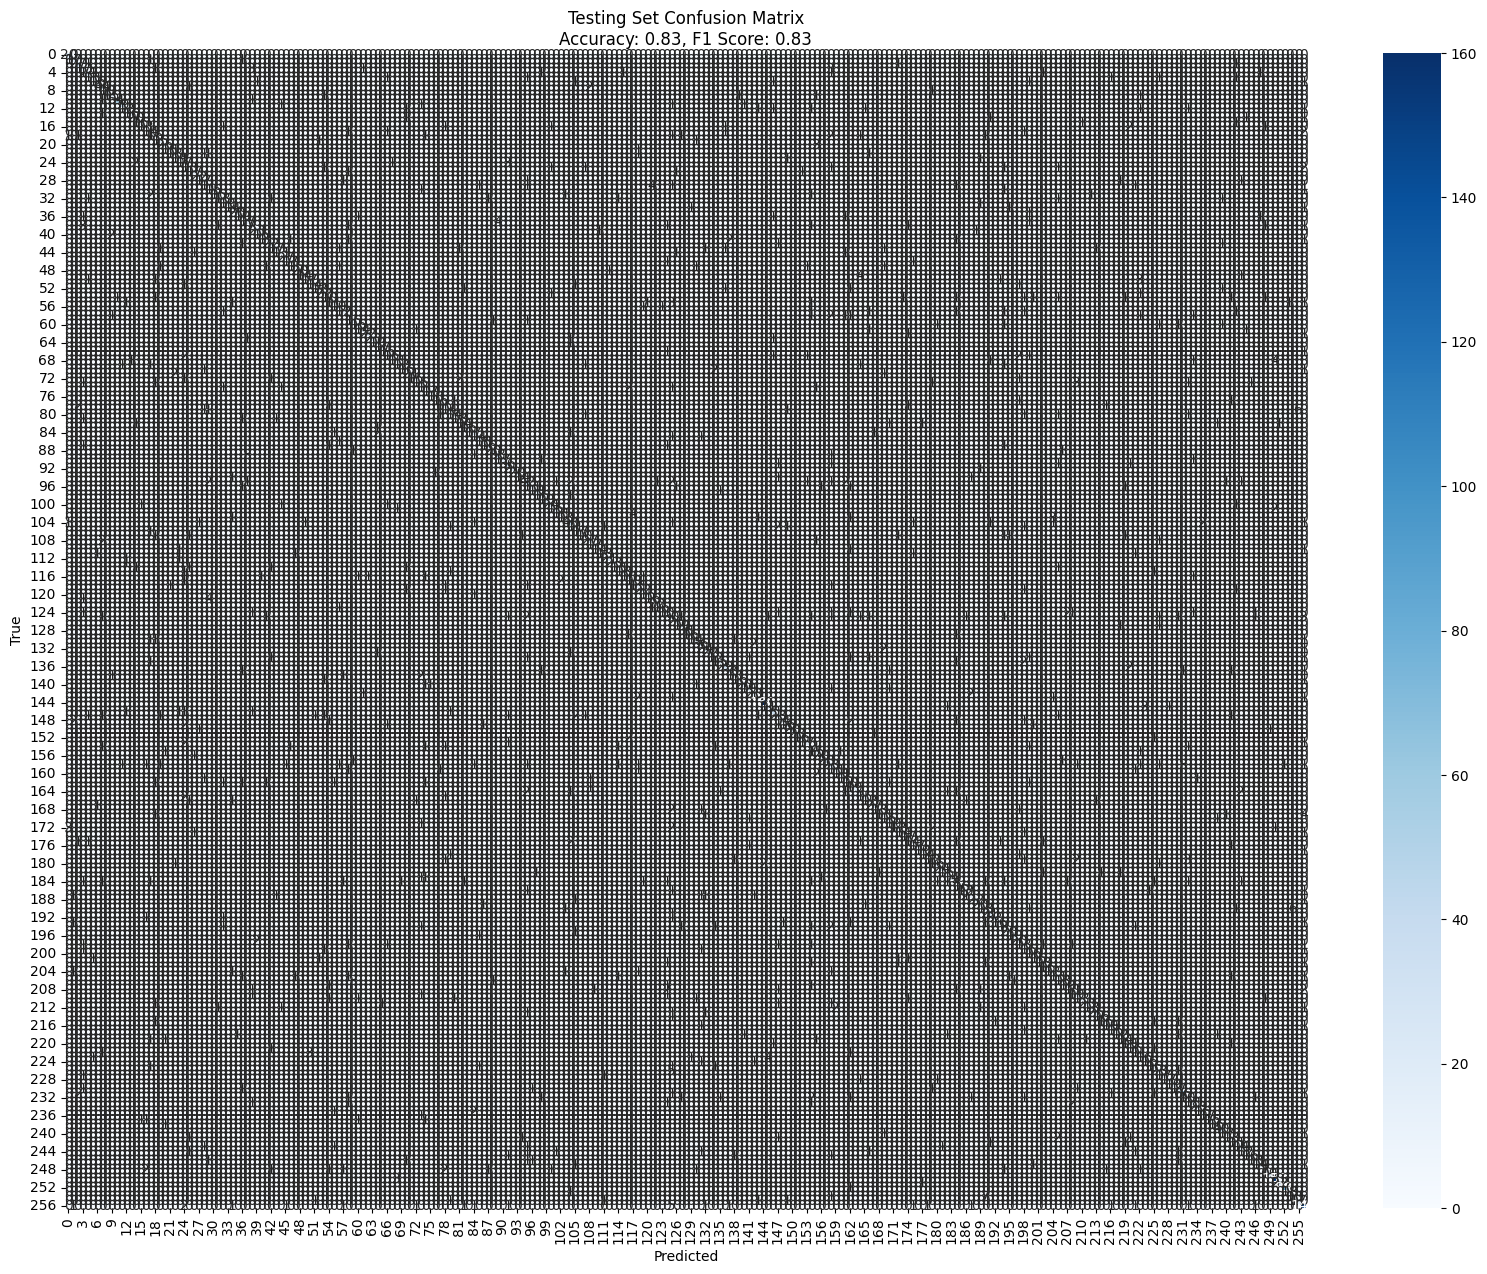

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features_lda, train_labels_encoded)

# Evaluate the classifier using cross-validation
cv_scores = cross_val_score(classifier, train_features_lda, train_labels_encoded, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')

# Training set predictions and evaluation
train_predictions = classifier.predict(train_features_lda)
train_accuracy = accuracy_score(train_labels_encoded, train_predictions)
train_f1 = f1_score(train_labels_encoded, train_predictions, average='weighted')
train_cm = confusion_matrix(train_labels_encoded, train_predictions)
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Training F1 Score: {train_f1:.2f}')

# Testing set predictions and evaluation
test_predictions = classifier.predict(test_features_lda)
test_accuracy = accuracy_score(test_labels_encoded, test_predictions)
test_f1 = f1_score(test_labels_encoded, test_predictions, average='weighted')
test_cm = confusion_matrix(test_labels_encoded, test_predictions)
print(f'Testing Accuracy: {test_accuracy:.2f}')
print(f'Testing F1 Score: {test_f1:.2f}')

# Plot confusion matrix function
def plot_confusion_matrix(cm, title, accuracy, f1_score):
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title}\nAccuracy: {accuracy:.2f}, F1 Score: {f1_score:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
# Plot training confusion matrix
plot_confusion_matrix(train_cm, 'Training Set Confusion Matrix', train_accuracy, train_f1)
# Plot testing confusion matrix
plot_confusion_matrix(test_cm, 'Testing Set Confusion Matrix', test_accuracy, test_f1)


In [11]:
report = classification_report(test_labels_encoded, test_predictions, target_names=label_encoder.classes_)
print(report)

                               precision    recall  f1-score   support

                     001.ak47       0.80      1.00      0.89        20
            002.american-flag       0.74      0.89      0.81        19
                 003.backpack       0.82      0.90      0.86        30
             004.baseball-bat       0.53      0.68      0.60        25
           005.baseball-glove       0.83      0.80      0.81        30
          006.basketball-hoop       0.87      0.72      0.79        18
                      007.bat       0.89      0.76      0.82        21
                  008.bathtub       0.83      0.94      0.88        47
                     009.bear       1.00      0.95      0.97        20
                 010.beer-mug       0.79      0.79      0.79        19
                011.billiards       0.98      0.96      0.97        56
               012.binoculars       0.95      0.91      0.93        43
                 013.birdbath       0.75      0.60      0.67        20
     

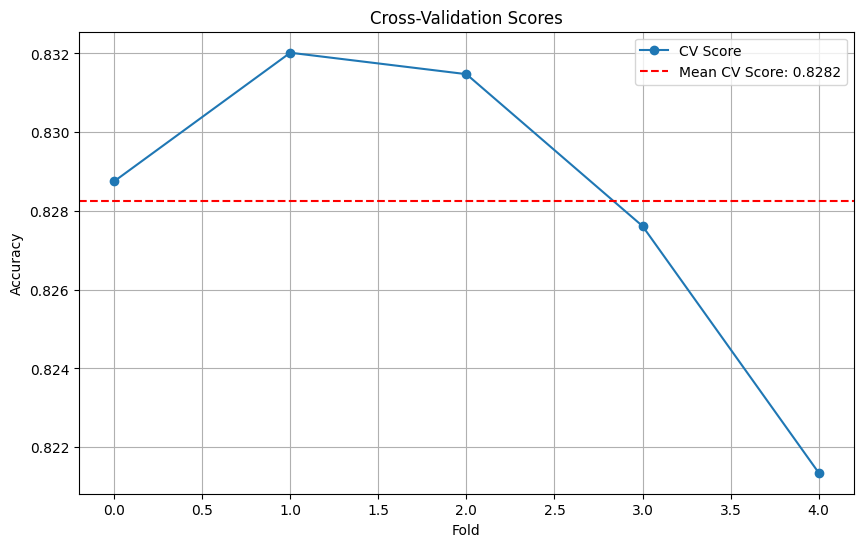

In [12]:
# Cross-Validation Scores
cv_scores = [0.82875034, 0.83201742, 0.83147291, 0.82761438, 0.82135076]

# Mean CV Score
mean_cv_score = np.mean(cv_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cv_scores, marker='o', linestyle='-', label='CV Score')
plt.axhline(y=mean_cv_score, color='r', linestyle='--', label=f'Mean CV Score: {mean_cv_score:.4f}')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Train Recall@K: {1: 0.6994499809399336, 5: 0.8389696672656973, 10: 0.8805206121004193}
Validation Recall@K: {1: 0.6862136556680823, 5: 0.8270173146030709, 10: 0.8678536426004574}


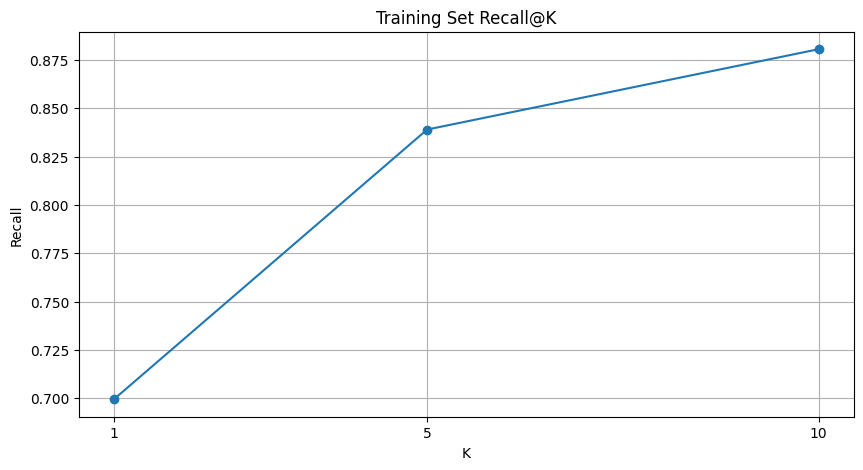

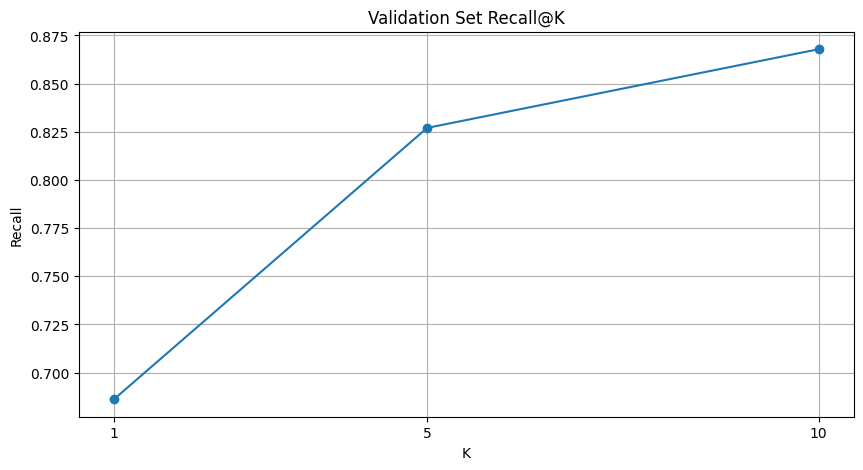

In [13]:
def recall_at_k(features, labels, k):
    num_samples = len(labels)
    correct_at_k = 0

    for i in range(num_samples):
        distances = np.linalg.norm(features - features[i], axis=1)
        sorted_indices = np.argsort(distances)
        sorted_labels = labels[sorted_indices]

        # Check if the true label is within the top k
        if labels[i] in sorted_labels[1:k+1]:  # Exclude the 0th index since it's the query itself
            correct_at_k += 1

    recall = correct_at_k / num_samples
    return recall

# Compute Recall@K for training and validation sets
k_values = [1, 5, 10]
train_recalls = {k: recall_at_k(train_features_pca, train_labels_encoded, k) for k in k_values}
val_recalls = {k: recall_at_k(val_features_pca, val_labels_encoded, k) for k in k_values}

print(f"Train Recall@K: {train_recalls}")
print(f"Validation Recall@K: {val_recalls}")

def plot_recall_at_k(recalls, k_values, title):
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, [recalls[k] for k in k_values], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('K')
    plt.ylabel('Recall')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

# Plot Recall@K curves
plot_recall_at_k(train_recalls, k_values, 'Training Set Recall@K')
plot_recall_at_k(val_recalls, k_values, 'Validation Set Recall@K')

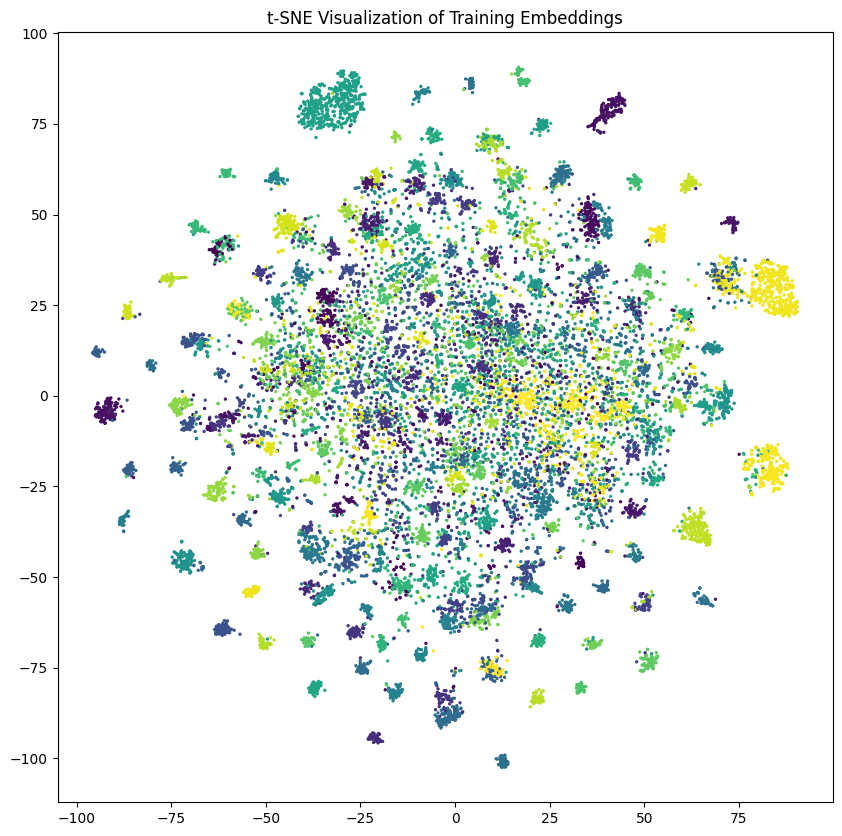

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# t-SNE Visualization
tsne = TSNE(n_components=2)
train_tsne = tsne.fit_transform(train_features_pca)
plt.figure(figsize=(10, 10))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels_encoded, cmap='viridis', s=2)
plt.title('t-SNE Visualization of Training Embeddings')
plt.show()

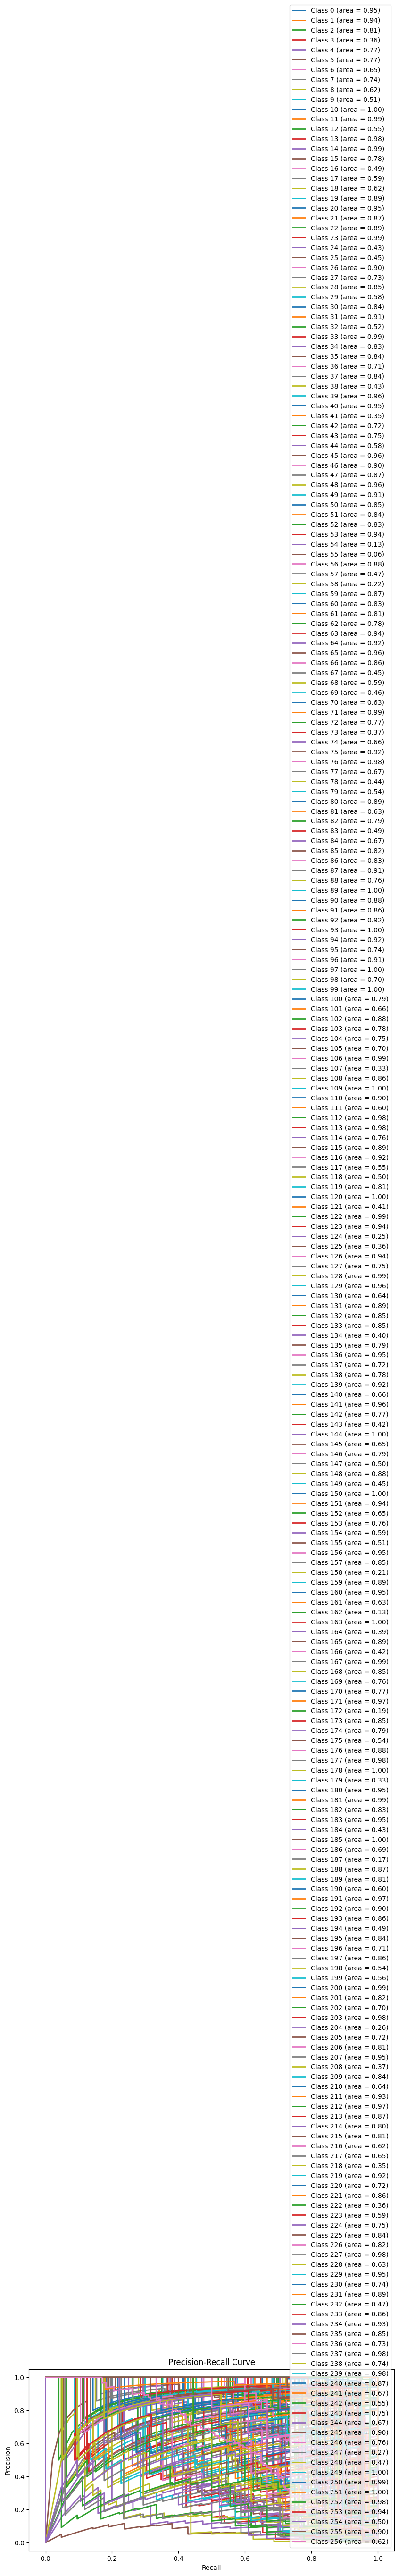

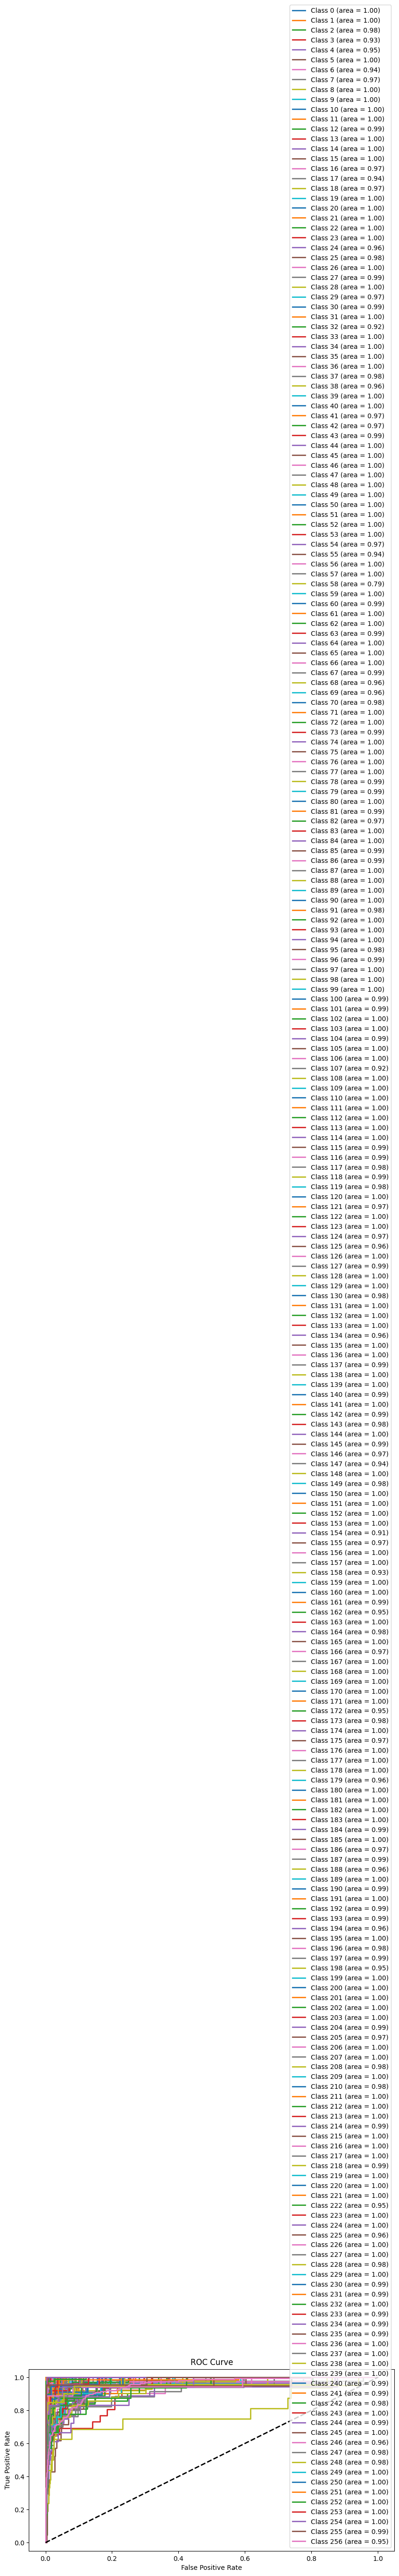

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


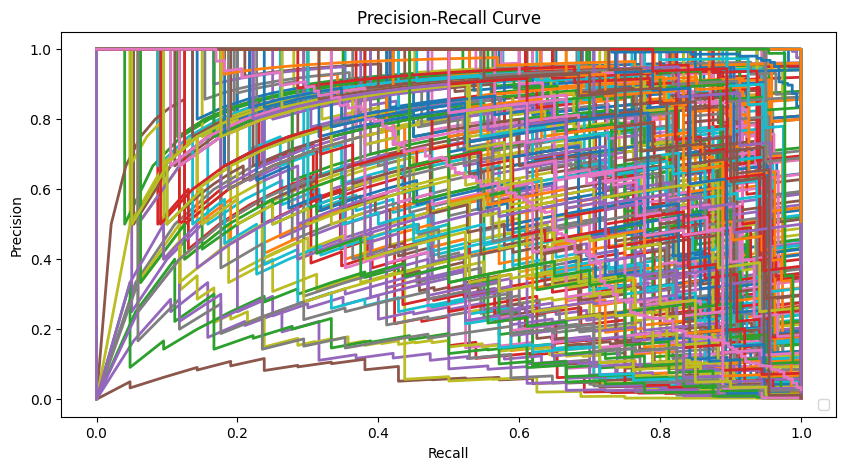

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


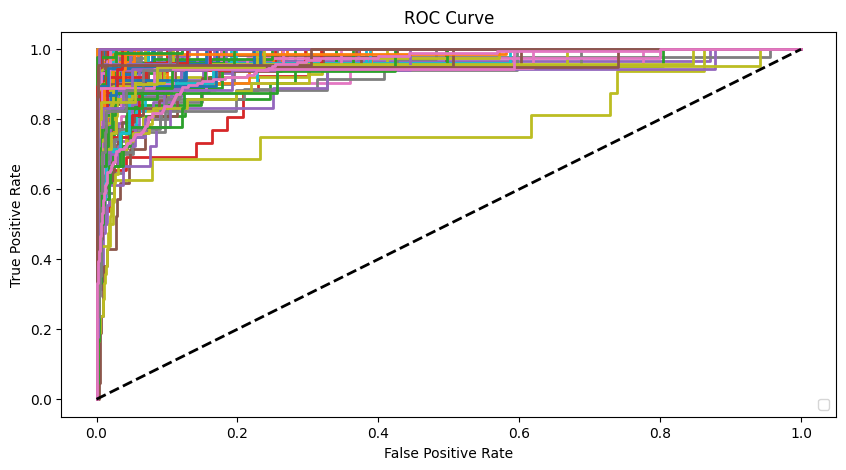

In [ ]:
# Binarize the labels for multiclass classification
val_labels_binarized = label_binarize(val_labels_encoded, classes=np.unique(val_labels_encoded))
n_classes = val_labels_binarized.shape[1]

# Precision-Recall Curve and ROC Curve for each class
precision = dict()
recall = dict()
roc_auc = dict()
fpr = dict()
tpr = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(val_labels_binarized[:, i], classifier.decision_function(val_features_lda)[:, i])
    fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], classifier.decision_function(val_features_lda)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (area = {auc(recall[i], precision[i]):0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2)#, label=f'Class {i} (area = {auc(recall[i], precision[i]):0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()